Preprocessing: Checking data objects 

In [4]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

# Data retrieval
sc.settings.set_figure_params(dpi=50, facecolor="white")

# Load your liver FACS Smart-seq2 data
adata = sc.read_h5ad("tabula-muris-senis-facs-processed-official-annotations-Liver.h5ad")  # path to your file

# Make sure variable (gene) names are unique
adata.var_names_make_unique()

# Make sure observation (cell) names are unique
adata.obs_names_make_unique()

# Inspect AnnData object
print(adata)

#display the pandas crosstab 
print(pd.crosstab(adata.obs['age'], adata.obs['mouse.id']))

AnnData object with n_obs × n_vars = 2859 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
mouse.id  3_9_M  3_11_M  3_56_F  3_57_F  18_45_M  18_46_F  18_53_M  24_58_M  \
age                                                                           
3m          150     420      82      79        0        0        0        0   
18m           0       0       0       0      275      533      372        0   
24m           0       0       0       0        0        0        0      508   

mouse.id  24_59_M  
age                
3m              0  
18m             0  
24m   

c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


In this data we have 2859 cells total and 22966 genes. These cells come from mice that have different ages and sexes, specifically: 4 mice (2 male and two female) with 3 months, 3 mice (2 male and 1 female) with 18 months and 2 (2 male) mice with 24 months.

Here the batch effect must be studied carefully because there are many variables that could be interpreted as such when actually they are biological differences derived from any one of these variables (age and sex), assuming that the mice with the same age and sex are replicates.

QC

Specific gene IDs like Mt and HB can't be used because my data uses Ensembl style IDs, meaning that these prefixes don't match any gene and the counts that they would produce would be zero.

And since the data doesnt provide the gene IDs for mapping, the only option would be to use a lookup table. Since I am more interested in the clustering per cell type, I will skip specific gene counts.

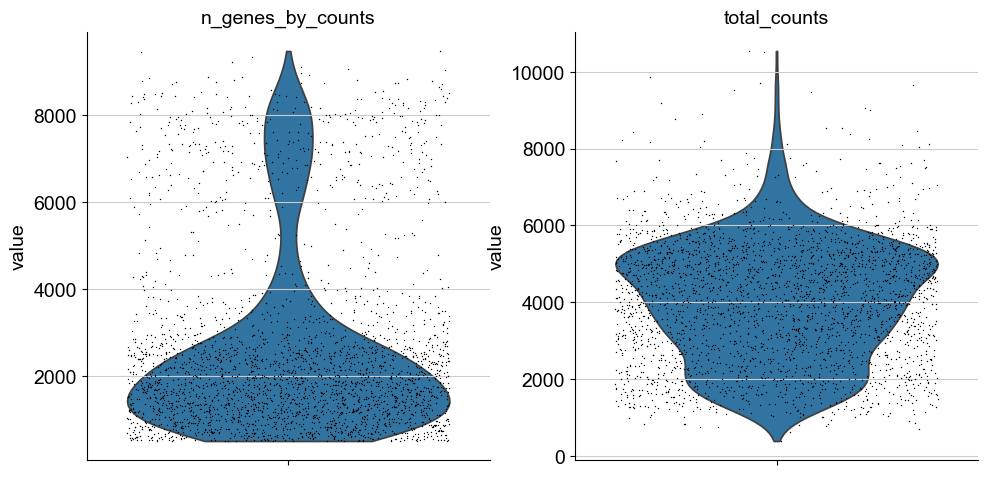

In [5]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

# Calculate basic QC metrics (without gene sets)
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Violin plots for key QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts'],
    jitter=0.4,
    multi_panel=True,
)


These are the violin plots for the full data.

On the left we have the Number of unique gene counts per cell. 

Shows how many unique genes were detected with a least one count per cell. The y-axis shows the number of genes and the x-axis shows the individual cells. In this case we can see that the larger subset of cells appears to be around 2000 unique genes per cell, with another much smaller subset of cells with 8000 unique genes.

What this means: the larger subset is most likely high quality data, since this is the expected number for smartseq2 data, while the smaller subset may be doublets (two cells captured together) or very highly sequenced cells, which one explanation for such a large increase in unique genes in these cells.

On the right we have the Total gene counts per cell.

Shows the sum of total reads across all genes in a given cell. The y-axis shows the value of the gene count and the x-axis the cells. Here we have a large distribution of cells that have total gene counts increasing from around 2000 all the way to a peak of around 5000. We see a dropoff in total gene counts, with only a few outlier cells having higher total gene counts.

What this means: Again we see a main population of cells that have total gene counts of around 2000 to 5000 representing our main high quality population, which is in line with data from smartseq2. This gradual increase could be either doublets or, again, very well sequenced cells that, because they have higher depth, more genes were detected and individualized. Or it could have a biological reason, differing ages/sexes or cell types can express a different transcriptome.

To visualize both sex and age as potentials for a batch effect would be difficult in violin plots so lets do it in a scatter plot.

Created new categories in 'age_sex':
['18m_female', '18m_male', '24m_male', '3m_male', '3m_female']




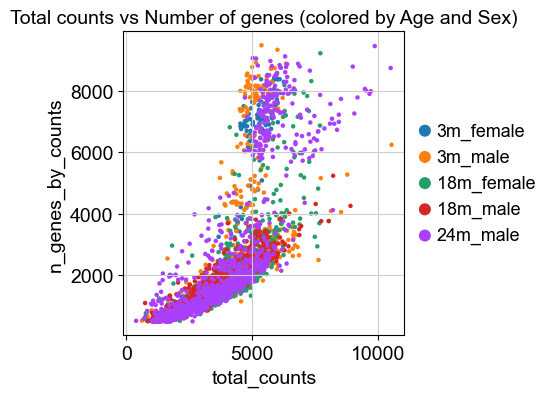

In [6]:
# --- Create a new metadata column by combining 'age' and 'sex' ---
# Ensure 'age' is a string to combine it with 'sex'
adata.obs['age_sex'] = adata.obs['age'].astype(str) + '_' + adata.obs['sex'].astype(str)

print("Created new categories in 'age_sex':")
print(adata.obs['age_sex'].unique().tolist())
print("\n") # Add a newline for readability

# --- Plot using the new combined column for color ---
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="age_sex",  # Use the new combined column
    title="Total counts vs Number of genes (colored by Age and Sex)"
)

Scatter plot graph shows the comparison between total gene counts per cell in the x-axis and number of unique gene counts per cell in the y-axis.

There is a higher concentration of cells across the comparison between the two axis around 2000 to 4000 number of unique genes and 0 to 5000 total gene counts. This is our main population of cells. Then we can see that there are more than a few "outliers", could even be a smaller population of cells, that have higher overall unique gene counts but not total gene counts. This could be technical errors or they could be biological differences since we can see that not all groups are represented in this smaller population, like the 18 month male mouse.

What this means: This graph corroborates the information given by the violin plots, with the identification of the subset that could be doublets or biological heterogeneity. The subtle difference in the categories could be sufficient for a batch correction, if it is caused by technical factors, but the information so far is insufficient to say.

Doublet Detection

The tutorial says: "We can remove doublets by either filtering out the cells called as doublets, or waiting until we’ve done a clustering pass and filtering out any clusters with high doublet scores."

My batch effects were minor, if at all present, but it is still recommended to do a doublet detection and possible removal before a possible batch correction. Since leaving them until after a first clustering pass may create clusters where doublets dominate. 

In [7]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

# Run Scrublet doublet detection, per sample/batch
sc.pp.scrublet(adata)  # or "sample" if you prefer

# Quick look at the added columns
print(adata.obs[['doublet_score', 'predicted_doublet']].head())

# Check the total number of cells before filtering
original_counts = adata.n_obs
print("Original counts before removing doublets:")
print(original_counts)

# Check number of predicted doublets
doublet_counts = adata.obs['predicted_doublet'].sum()
print("\nNumber of predicted doublets:")
print(doublet_counts)

# Remove predicted doublets
#adata = adata[~adata.obs['predicted_doublet'], :].copy()

# Save filtered data
#adata.write("Liver_facs_filtered.h5ad")

                                       doublet_score  predicted_doublet
index                                                                  
A10_B000767_B009945_S10.mm10-plus-4-0       0.040253              False
A10_D045313_B009942_S10.mm10-plus-4-0       0.014677              False
A11_B000767_B009945_S11.mm10-plus-4-0       0.057540              False
A11_B001247_B009941_S11.mm10-plus-4-0       0.026250              False
A11_B002688_B009944_S11.mm10-plus-4-0       0.036540              False
Original counts before removing doublets:
2859

Number of predicted doublets:
1


This output is in line with the interpretations of the distributions of the violin and scatter plots that saw a minor amount of cells belonging to the outlier groups of cells. Since this is a single cell, even if I am using a tool and code recommended by the ScanPy tutorial, I will not remove it from the dataset because it won't even relatively affect the downstream analysis and it could still prove beneficial.

Normalization

Here I normalized the data based on the metric suggested by the ScanPy tutorial of median count depth with log1p transformation.

Since I didn't actually filter the data we will be still be using the original dataset file, but I will keep the lines of code for clarity.

In [8]:
# Load the filtered of doublets data
#adata = sc.read_h5ad("Liver_facs_filtered.h5ad")
#adata.var_names_make_unique()
#adata.obs_names_make_unique()

# Save the raw counts in a separate layer
adata.layers["counts"] = adata.X.copy()

# Normalize each cell by total counts to median count depth
sc.pp.normalize_total(adata)  # default: target_sum = median count depth

# Log1p transform (log(x + 1))
sc.pp.log1p(adata)

# Quick check
print(adata)

# After normalization and log1p
adata.write("Liver_facs_normalized.h5ad")

AnnData object with n_obs × n_vars = 2859 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age_sex', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca', 'age_sex_colors', 'scrublet', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


The normalized and log1p transformed data are now saved as objects in the file, and are accessable for downstream analysis.

Feature Selection

Here I want to reduce the dimensionality of the dataset and only include the most informative genes. To identify genes that exhibit high cell-to-cell variability, as these are more likely to be biologically significant and useful for distinguishing different cell types and states.

The result of the output will be the selection of 2000, as instructed by the tutorial, highly variable genes (HGV) and the remaining difference of non HGVs.

highly_variable
False    20966
True      2000
Name: count, dtype: int64


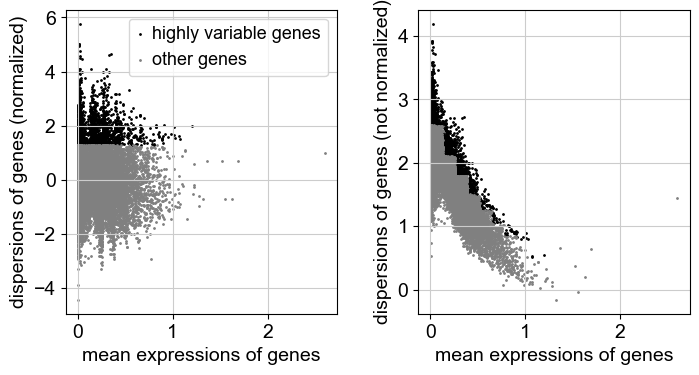

In [9]:
# Load the filtered, normalized data
adata = sc.read_h5ad("Liver_facs_normalized.h5ad")
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Highly variable gene selection
# n_top_genes = 2000 as in the tutorial
# batch_key = "batch" to account for multiple batches
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# Quick check of HVG annotation
print(adata.var.highly_variable.value_counts())

# Plot the highly variable genes
sc.pl.highly_variable_genes(adata)

# Save the HVG-annotated data for the next step
adata.write("Liver_facs_normalized_HVG.h5ad")

The left plot (NORMALIZED). Here it hows in the x-axis the average expression level of each gene across all cells and in the y-axis the variability of each gene's expression. Dispersion is a measure of how much the gene's expression varies from its mean value. where the dispersion values have been standardized. This normalization process typically involves fitting a model to the mean-dispersion trend observed and then calculating a z-score or a residual (difference between the actual point and the model fitted point) for each gene.

The right plot (NOT NORMALIZED). Typically, genes with higher mean expression tend to have lower dispersion (less variability relative to their mean), which is the trend followed by the grey points ("other genes"). The genes identified as "highly variable genes" (HVGs), marked in black, are those that deviate significantly from this expected trend. They show a higher dispersion than other genes with a similar mean expression level. This indicates that their variability is not just a consequence of their expression level but is likely driven by underlying biological processes.

What this means: The "highly variable genes" (black dots) are now clearly identifiable as the points with high positive normalized dispersion scores. This plot confirms that the selection has successfully captured genes with variability that is statistically significant above the technical noise and the expected biological variance.

Dimensionality Reduction

Here we aim to reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data. I will use only the highly variable genes (HVGs) for PCA.

c:\Users\lukas\miniconda3\envs\sc_env\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


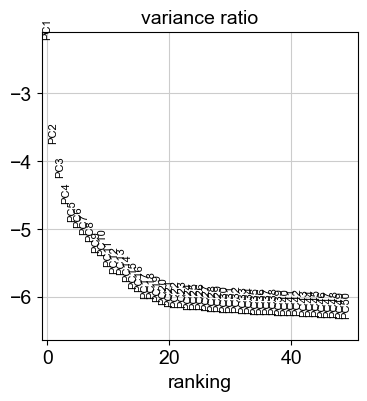

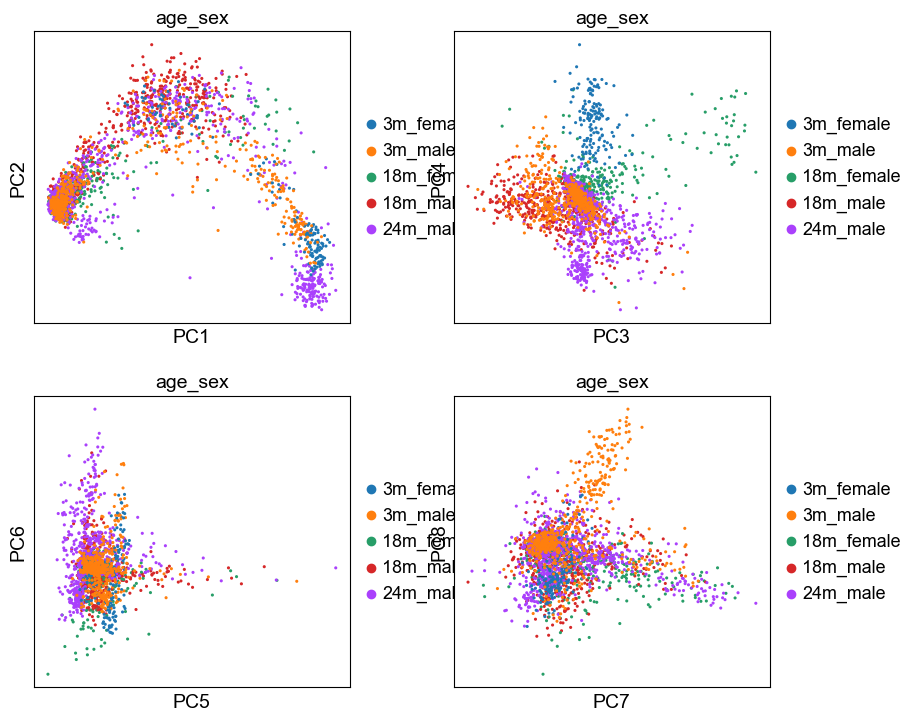

PCA done. Dataset shape: (2859, 22966)


In [10]:

# Load the HVG-only dataset from feature selection step
adata = sc.read_h5ad("Liver_facs_normalized_HVG.h5ad")
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Scale the data (zero mean, unit variance)
sc.pp.scale(adata, max_value=10)

# Run PCA
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

# Inspect variance explained by PCs
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, show=True)

# PCA scatter plots colored by batch
sc.pl.pca(
    adata,
    color=["age_sex"],  # "sample" is another option
    dimensions=[(0, 1), (2, 3), (4, 5), (6, 7)],
    ncols=2,
    size=20
)

# Save the PCA-processed dataset
adata.write("Liver_facs_normalized_HVG_reduced.h5ad")

print("PCA done. Dataset shape:", adata.shape)


The first plot gives us how much variance (relative importance) of each principal component (Scree Plot). Basically how much information each principal component captures, giving us a better perspective on how much information we can use in downstream analysis.

You want to keep enough PCs to capture the true biological signal in your data, but discard the later PCs which are more likely to represent technical noise. This plot helps you find the point of diminishing returns.

The plot shows a very gradual indicator of diminishing return of variance explained by later PCs. With an elbow possibly appearing around PC17 to PC20. This could be a good starting point to investigate as a means to keep biological heterogeneity. Of course, some technical noise may very likely be present but given that some of the cell types, like immune cells, are harder to distinguish a better granularity downstream is better.

The second plot shows us how the data was distributed and is compared between the principal components. Here we can see a good overall mix of the data in all 4 plots, indicating less batch effect that could be expected in a larger dataset. But we also see certain trends, especially because we have colored the plots by age_sex (our new column helping us identify biological differences). For example, comparing PC3 and PC4 there are different populations of cells trending in different directions, like 3 month female and 18 month female. This could indicate a biological signal that changes with age and not sex.

Batch Correction

We will skip batch correction for now. Since the data is very heterogenous and there are more than one biological variable the segregation by batches is harder to define and so it is harder to identify batch effects and justify their correction.

Clustering

First I will do the clustering based on the Leiden graph clustering method recommended by ScanPy, which creates a UMAP, on the dataset (without any batch correction). The UMAP is jsut another way to further reduce the dimensionality of the data, using the PCA analysis, to create a neighbouring graph we correlates points based on how similar and dissimilar they are, creating clusters of similar points based on the PCA information.

Loading data with pre-computed PCA from Liver_facs_normalized_HVG_reduced.h5ad...
Building neighborhood graph...
Running Leiden clustering for multiple resolutions...

Clustering results for multiple resolutions have been stored:
                                      leiden_0.5 leiden_0.75 leiden_1.0
index                                                                  
A10_B000767_B009945_S10.mm10-plus-4-0          0           0          0
A10_D045313_B009942_S10.mm10-plus-4-0          1           1          1
A11_B000767_B009945_S11.mm10-plus-4-0          3           2          2
A11_B001247_B009941_S11.mm10-plus-4-0          6           3          3
A11_B002688_B009944_S11.mm10-plus-4-0          5           4          5
Computing and plotting UMAP...

Plotting UMAPs for comparison...


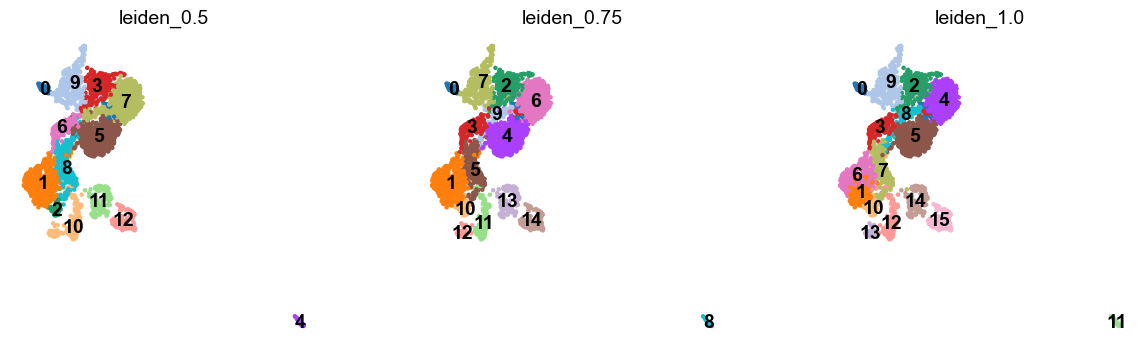

Saving clustered data to Liver_facs_normalized_HVG_reduced_clustered.h5ad...

 Clustering script finished successfully.


In [11]:
# Define the input file (your data with PCA already computed)
# and the name for the output file.
input_file = "Liver_facs_normalized_HVG_reduced.h5ad"
output_file = "Liver_facs_normalized_HVG_reduced_clustered.h5ad"

# --- 2. LOAD THE PRE-COMPUTED PCA DATA ---
print(f"Loading data with pre-computed PCA from {input_file}...")
adata = sc.read_h5ad(input_file)

# --- 3. BUILD NEIGHBORHOOD GRAPH ---
# This step uses the PCA results already stored in adata.obsm['X_pca'].
# We are creating the neighborhood graph based on the data.
print("Building neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

# --- 4. LEIDEN CLUSTERING ON DATA ---
print("Running Leiden clustering for multiple resolutions...")

# --- Resolution 0.5 ---
sc.tl.leiden(
    adata,
    resolution=0.5,
    key_added='leiden_0.5',  # Store result in 'leiden_0.5'
    flavor="igraph",
    n_iterations=2
)

# --- Resolution 0.75 ---
sc.tl.leiden(
    adata,
    resolution=0.75,
    key_added='leiden_0.75', # Store result in 'leiden_0.75'
    flavor="igraph",
    n_iterations=2
)

# --- Resolution 1.0 ---
sc.tl.leiden(
    adata,
    resolution=1.0,
    key_added='leiden_1.0',  # Store result in 'leiden_1.0'
    flavor="igraph",
    n_iterations=2
)

# --- Verification ---
# You can now see all three results stored as separate columns in adata.obs
print("\nClustering results for multiple resolutions have been stored:")
print(adata.obs[['leiden_0.5', 'leiden_0.75', 'leiden_1.0']].head())

# --- 5. VISUALIZATION ---
# Compute the UMAP based on the graph.
print("Computing and plotting UMAP...")
sc.tl.umap(adata)

# Plot the UMAP colored by the resulting clusters and by batch.
# You should see a strong correlation between the two.
print("\nPlotting UMAPs for comparison...")
sc.pl.umap(
    adata,
    color=['leiden_0.5', 'leiden_0.75', 'leiden_1.0'], # Pass the list of your results here
    legend_loc='on data', # Puts the cluster number directly on the plot
    frameon=False,
    ncols=3 # Arrange the plots in a row with 3 columns
)
# --- 6. SAVE THE CLUSTERED DATA ---
print(f"Saving clustered data to {output_file}...")
adata.write(output_file)

print("\n Clustering script finished successfully.")

Here we can see a clustering of very closely connected points, possibly indicating a batch effect, since the borders of the clusters are somewhat poorly defined. Evaluating the clusters based on their Leiden resolution, which adds granularity and possible new clusters as it increases, we can see an increase of two new clusters from 0.5 to 0.75 resolution and then another cluster is added from 0.75 to 1.00. 

Based solely on this evaluation between these plots, I think the Leiden resolution at 1.0 may indicate a better representation of the data than the previous two. This is because the clusters it adds seem to be different populations that are closely connected to other populations. These could be the cell types described above, like immune cells, that more often than not express similar genes and in more simple analysis may be identified as a single cell type/family.

Cell Annotation

Here the goal is to assign a preliminary identity to your clusters based on existing biological knowledge. It answers the question: "Do my clusters correspond to the cell types I expect to find?".

In the manual annotation of the clusters to the cell types based on this marker set, I only assigned cell types to the clusters that presented above 50% fraction of cells in that group that had a high mean expression of a gene that corresponded with that cell type. I did not assign below 50% because I did not find that this expression was relevant enough in that little fraction of cells.

Generating dotplot for clusters in 'leiden_1.0'...


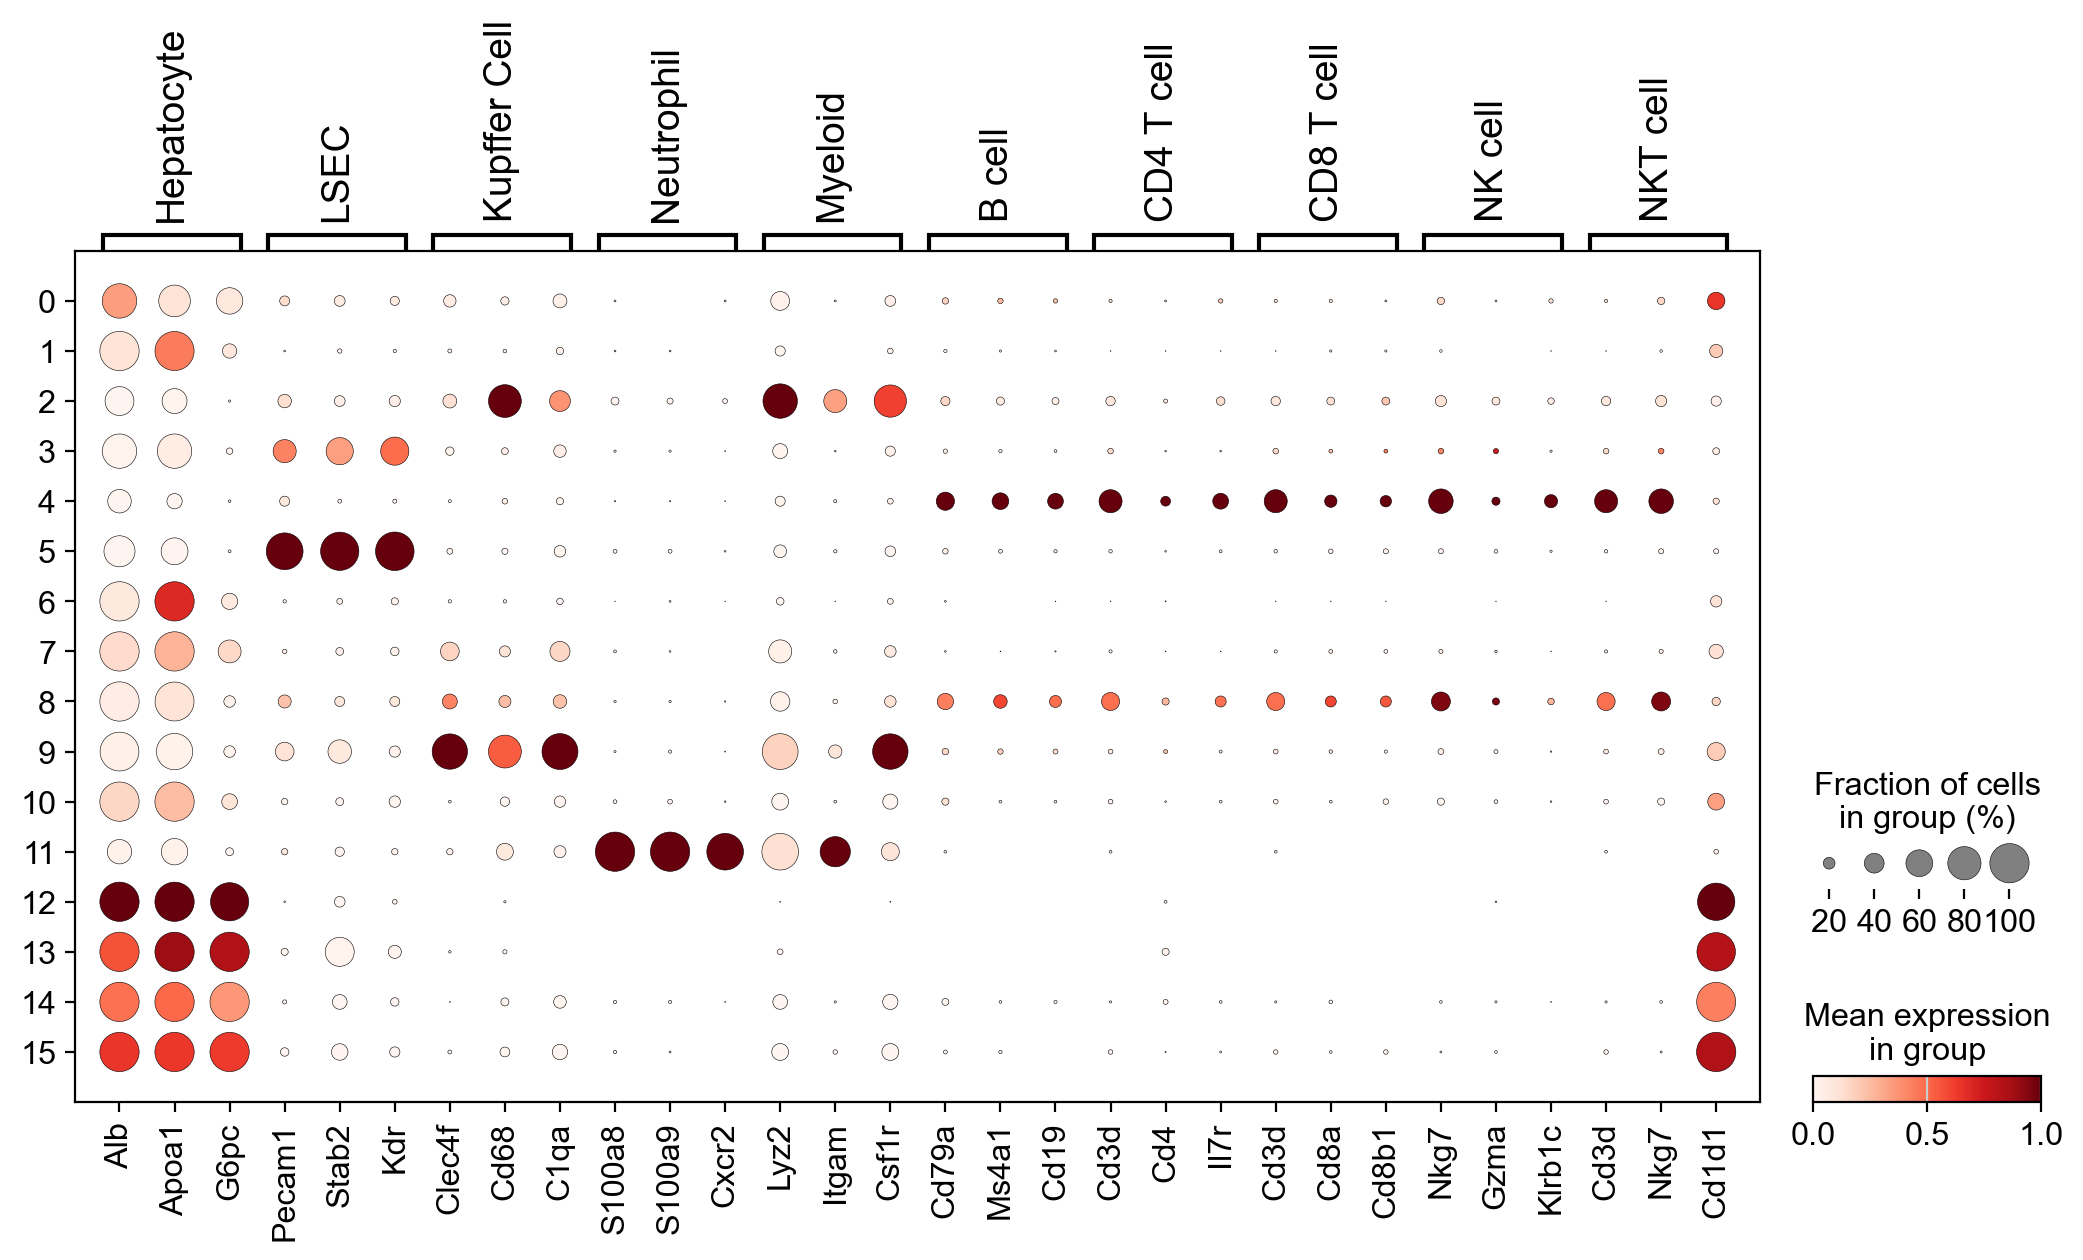


Finished mapping cluster numbers to cell type names.
Value counts for the new 'cell_type' annotation:
cell_type
Hepatocyte                752
LSEC                      621
Kupffer/Myeloid_mix       479
Immune_mix                462
Hepatocyte/NKT_mix        424
Hepatocyte/Immune_mix      87
Neutrophil/Myeloid_mix     34
Name: count, dtype: int64

Visualizing final annotation on UMAP...


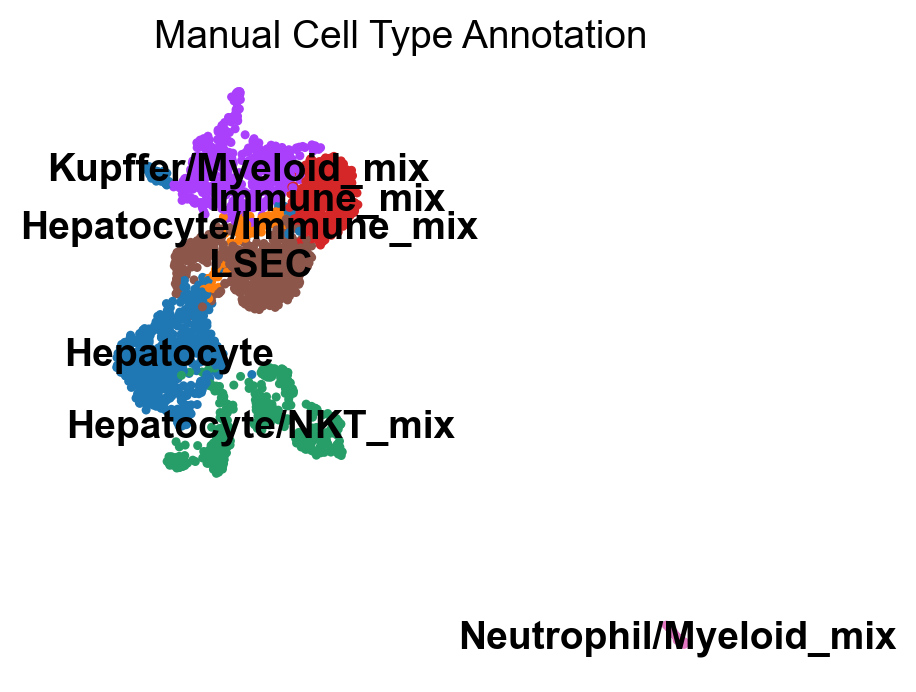


Visualizing final dotplot with cell type labels...


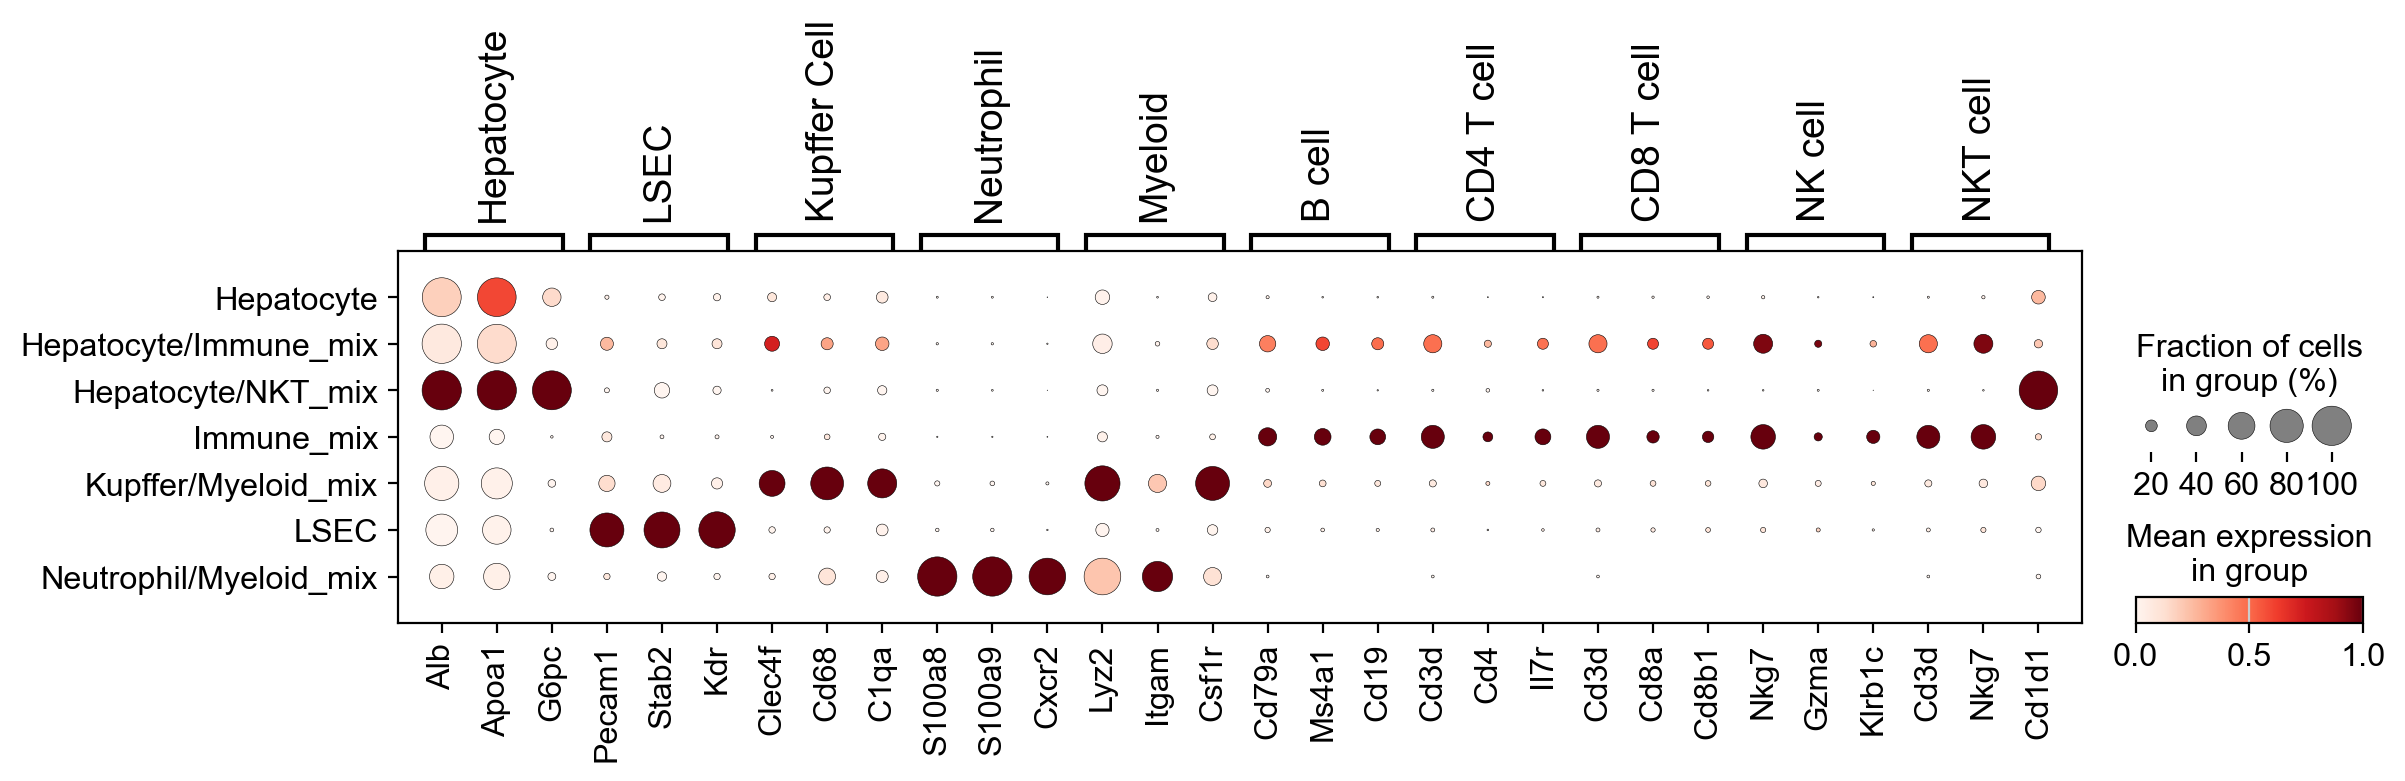

In [12]:
# --- Manual Annotation using Marker Genes for Liver Data ---
# Setup Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # Increased DPI for clarity

# 1. Load the AnnData object with clustering results
# Make sure this is the correct file containing your Leiden clustering column
adata = sc.read_h5ad('Liver_facs_normalized_HVG_reduced_clustered.h5ad')


# 2. Define the new, more detailed set of marker genes for LIVER cell types
# These markers are based on the cell types you provided.
new_liver_marker_genes = {
    'Hepatocyte': ['Alb', 'Apoa1', 'G6pc'],
    'LSEC': ['Pecam1', 'Stab2', 'Kdr'], # Liver Sinusoidal Endothelial Cells
    'Kupffer Cell': ['Clec4f', 'Cd68', 'C1qa'], # Liver-resident macrophages
    'Neutrophil': ['S100a8', 'S100a9', 'Cxcr2'],
    'Myeloid': ['Lyz2', 'Itgam', "Csf1r"], # General myeloid marker (includes many types)
    'B cell': ['Cd79a', 'Ms4a1',"Cd19"], # Ms4a1 is CD20
    'CD4 T cell': ['Cd3d', 'Cd4', 'Il7r'],
    'CD8 T cell': ['Cd3d', 'Cd8a', 'Cd8b1'],
    'NK cell': ['Nkg7', 'Gzma', 'Klrb1c'], # Natural Killer cells (CD3 negative)
    'NKT cell': ['Cd3d', 'Nkg7',"Cd1d1"], # NK T cells (express both CD3 and NK markers)
}


# 3. Choose a resolution and visualize marker expression with a dotplot
# Make sure this key matches a column in your adata.obs
cluster_key_to_annotate = "leiden_1.0" # Example: using resolution 0.75

print(f"Generating dotplot for clusters in '{cluster_key_to_annotate}'...")
sc.pl.dotplot(adata, new_liver_marker_genes, groupby=cluster_key_to_annotate, standard_scale="var", show=True)

# 4. Manually map cluster numbers to cell type names based on the NEW dotplot
#

annotation_map = {
    '0': 'Hepatocyte',
    '1': 'Hepatocyte', # CONFLICT: Was Hepatocyte AND Stellate Cell
    '2': 'Kupffer/Myeloid_mix',
    '3': 'LSEC',
    '4': 'Immune_mix', # CONFLICT: Was Hepatocyte AND Cholangiocyte
    '5': 'LSEC',
    '6': 'Hepatocyte',
    '7': 'Hepatocyte',
    '8': 'Hepatocyte/Immune_mix',
    '9': 'Kupffer/Myeloid_mix',
    '10': 'Hepatocyte',
    '11': 'Neutrophil/Myeloid_mix',
    '12': 'Hepatocyte/NKT_mix',
    '13': 'Hepatocyte/NKT_mix',
    '14': 'Hepatocyte/NKT_mix',
    '15': 'Hepatocyte/NKT_mix',
}
# Apply the mapping to create a new annotation column in adata.obs
if annotation_map: # Only run if the map is not empty
    adata.obs['cell_type'] = adata.obs[cluster_key_to_annotate].map(annotation_map).astype('category')
#
print("\nFinished mapping cluster numbers to cell type names.")
print("Value counts for the new 'cell_type' annotation:")
print(adata.obs['cell_type'].value_counts())
#
#     # 5. Visualize the final annotation on the UMAP
print("\nVisualizing final annotation on UMAP...")
sc.pl.umap(adata, color='cell_type', legend_loc='on data', title='Manual Cell Type Annotation', show=True)
#
#
#     # 6. Visualize the annotated dotplot for confirmation
print("\nVisualizing final dotplot with cell type labels...")
sc.pl.dotplot(adata, new_liver_marker_genes, groupby='cell_type', standard_scale='var', show=True)
#
#     # Optional: Save the final annotated object
adata.write_h5ad('Liver_facs_normalized_HVG_reduced_clustered_annotated.h5ad')

The second image is the result of the manual annotation. Perhaps the choice of higher resolution segregated the data too much, and as a consequence the annotation identified many clusters that are representative of the same cell types. But perhaps not, since the lowest recommended resolution of 0.5 had 12 clusters, and in the end the data has but 7 clusters. Is this the marker of batch effects? Is the marker gene set poorly characterized? Is there some biological signal I'm missing?

For the biological signal we can check if there are clusters dominated by single individuals, by coloring the graphs witht he added column of age_sex.

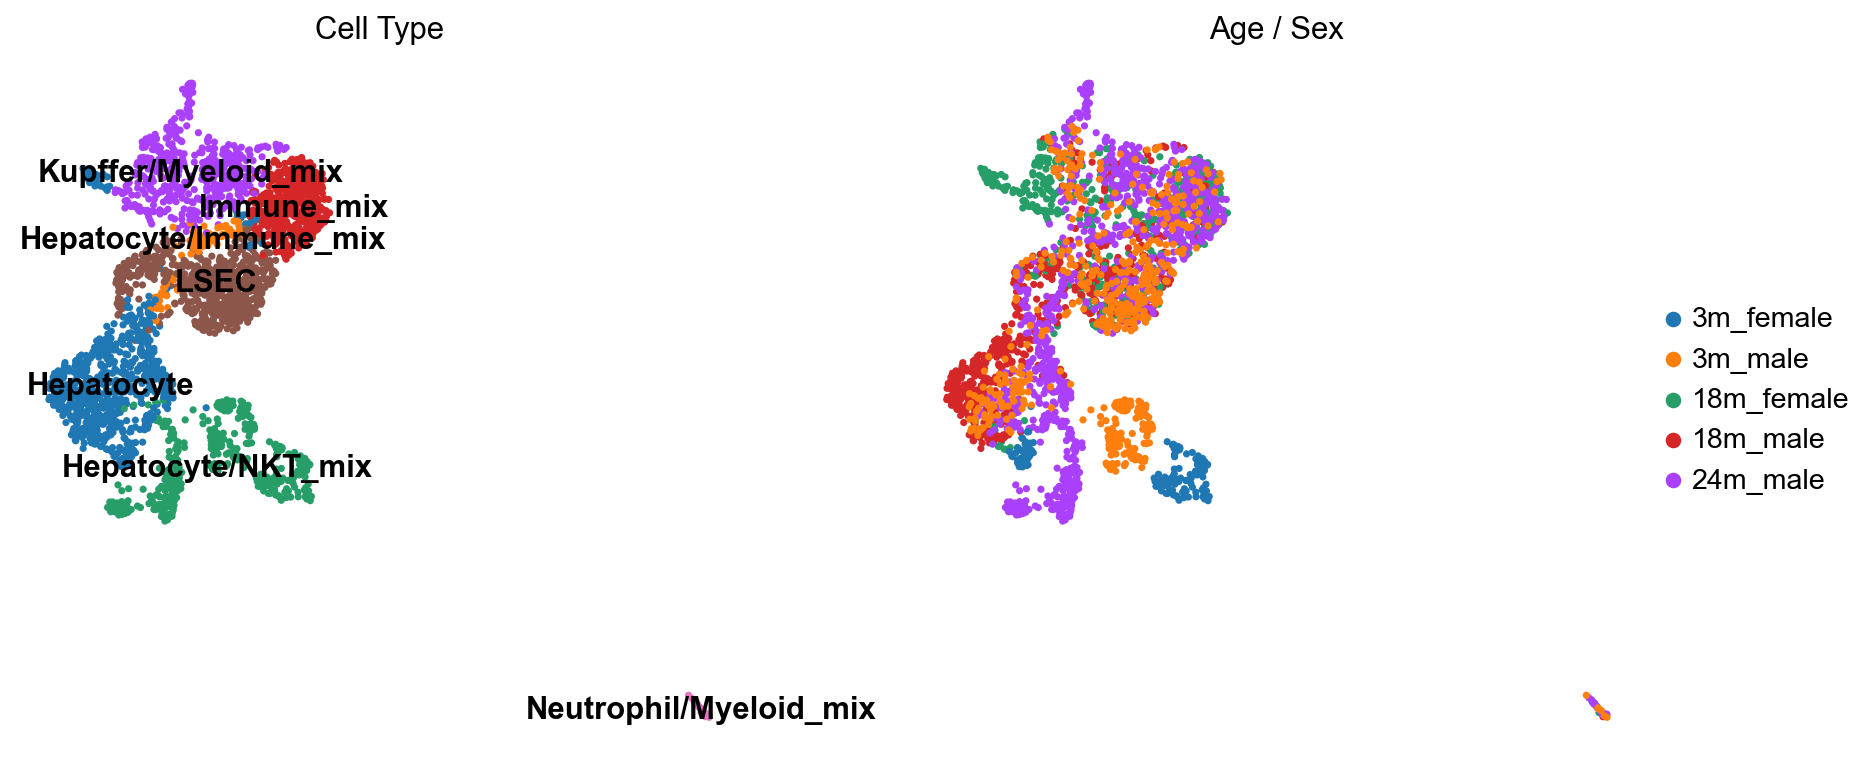

In [15]:
# 1. Create a figure with 1 row and 2 columns of subplots
# figsize controls the overall size of the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 2. Plot 'cell_type' on the first subplot (axes[0])
# legend_loc='on data' places the legend labels directly on the clusters
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[0],               # Specify the first subplot
    show=False,               # Do not show the plot immediately
    legend_loc='on data',     # Put the legend on the plot itself
    title='Cell Type'         # Add a title for clarity
)

# 3. Plot 'age_sex' on the second subplot (axes[1])
# legend_loc='right margin' is the default and places the legend outside
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[1],               # Specify the second subplot
    show=False,               # Do not show the plot immediately
    legend_loc='right margin',# Put the legend in the right margin
    title='Age / Sex'         # Add a title for clarity
)

# 4. Adjust spacing and display the final figure
plt.tight_layout()
plt.show()

Clearly there are some clusters dominated by a single individual, like cluster 14 and 15. And others where one individual is most represented, like 5 or 6. Further investigation is required.

Differentially expressed genes (DEG) 

Here the goal is to validate your annotations and discover the most defining features of each cluster in your specific dataset. It answers the question: "What does the data itself say is most special about these groups of cells?".

First of all the ScanPy tutorial suggests using Pseudobulking: It means you computationally "pool" the data. You take all the raw counts from the cells of a single type within one sample and add them together. This is better for a comparison of cell types between different groups, like sex and age. This is my case but I will save it for after the conventional approach.

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Displaying top marker genes for each annotated cell type:


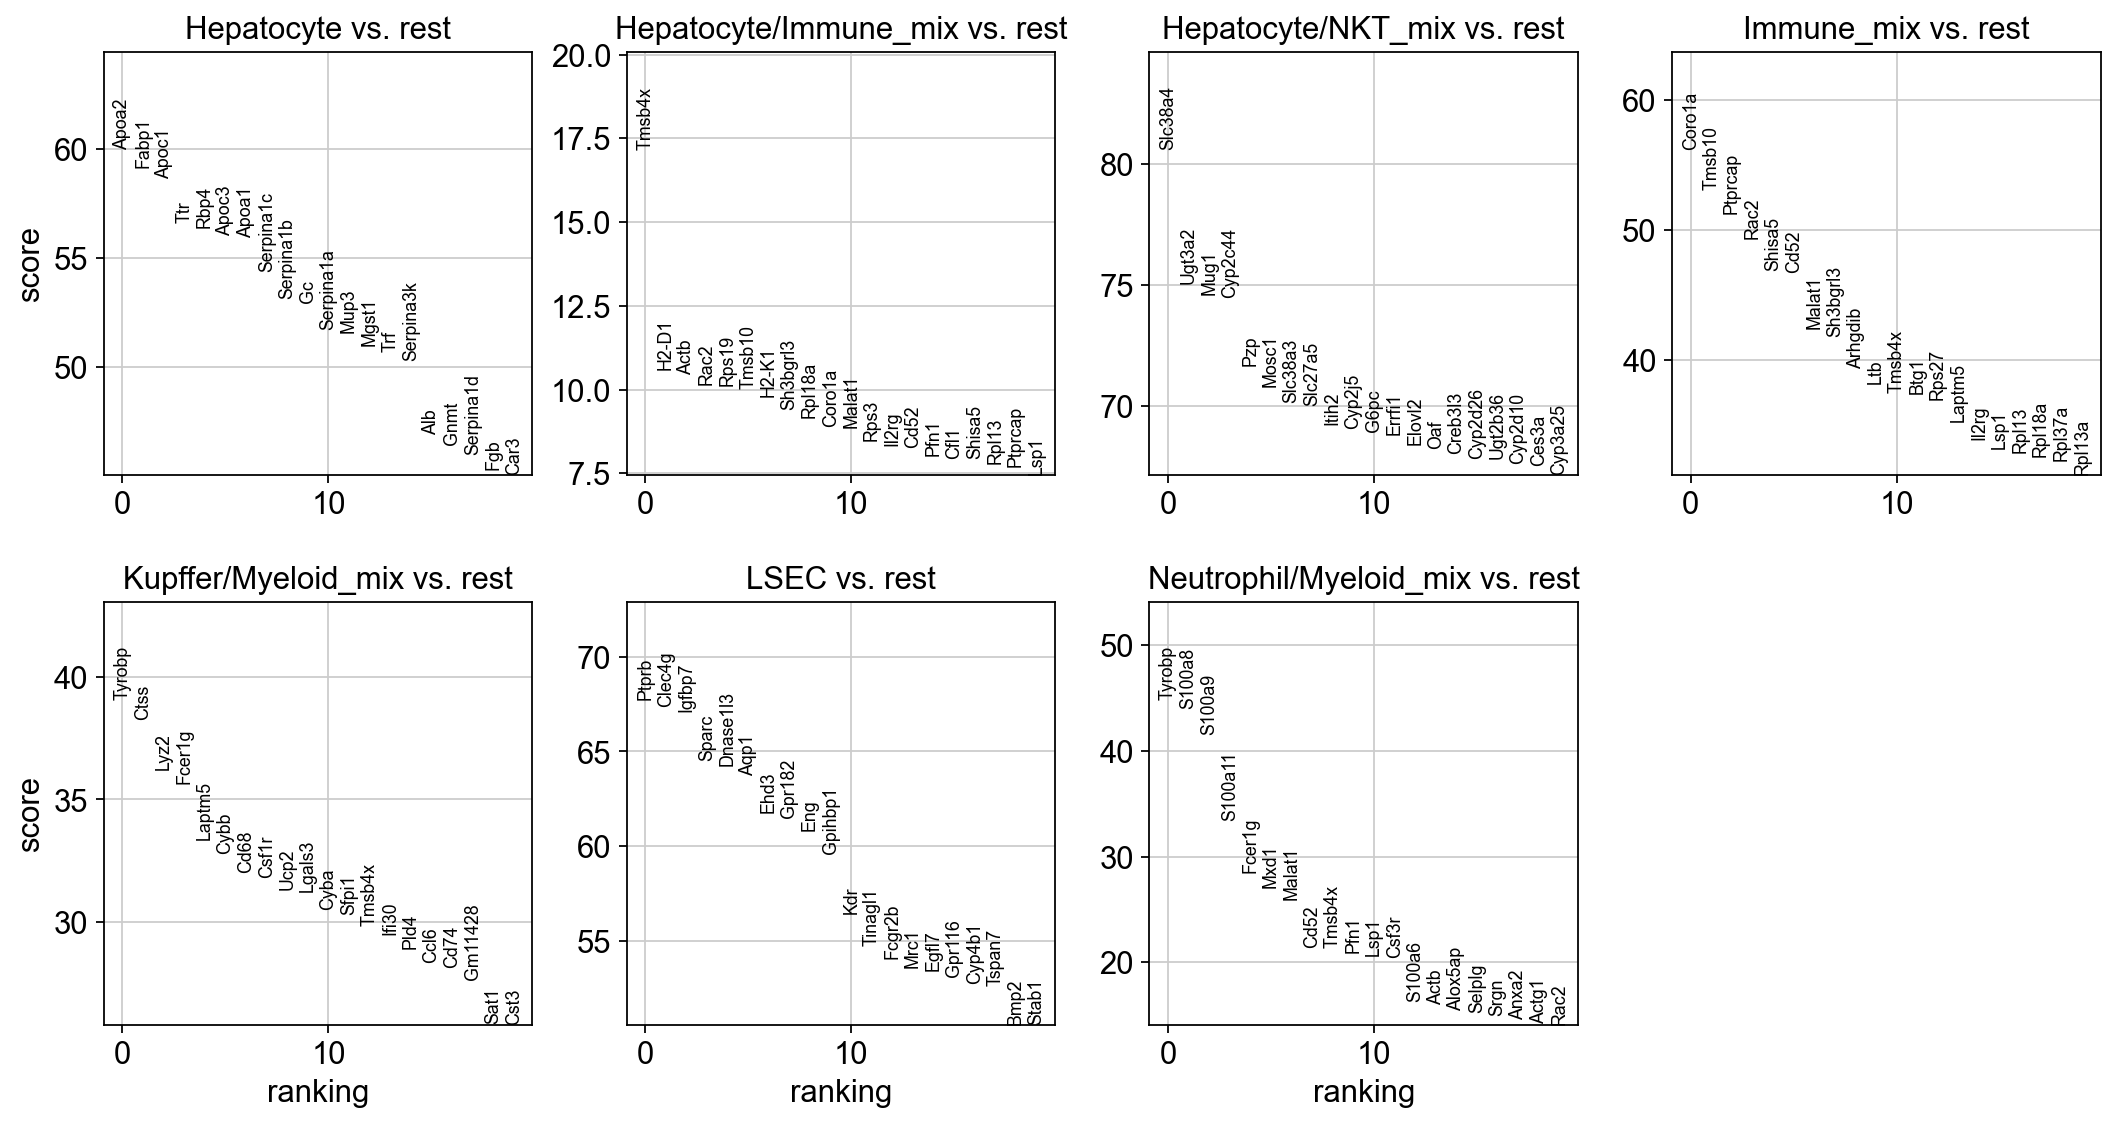


Displaying heatmap of top 10 markers per cell type:
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


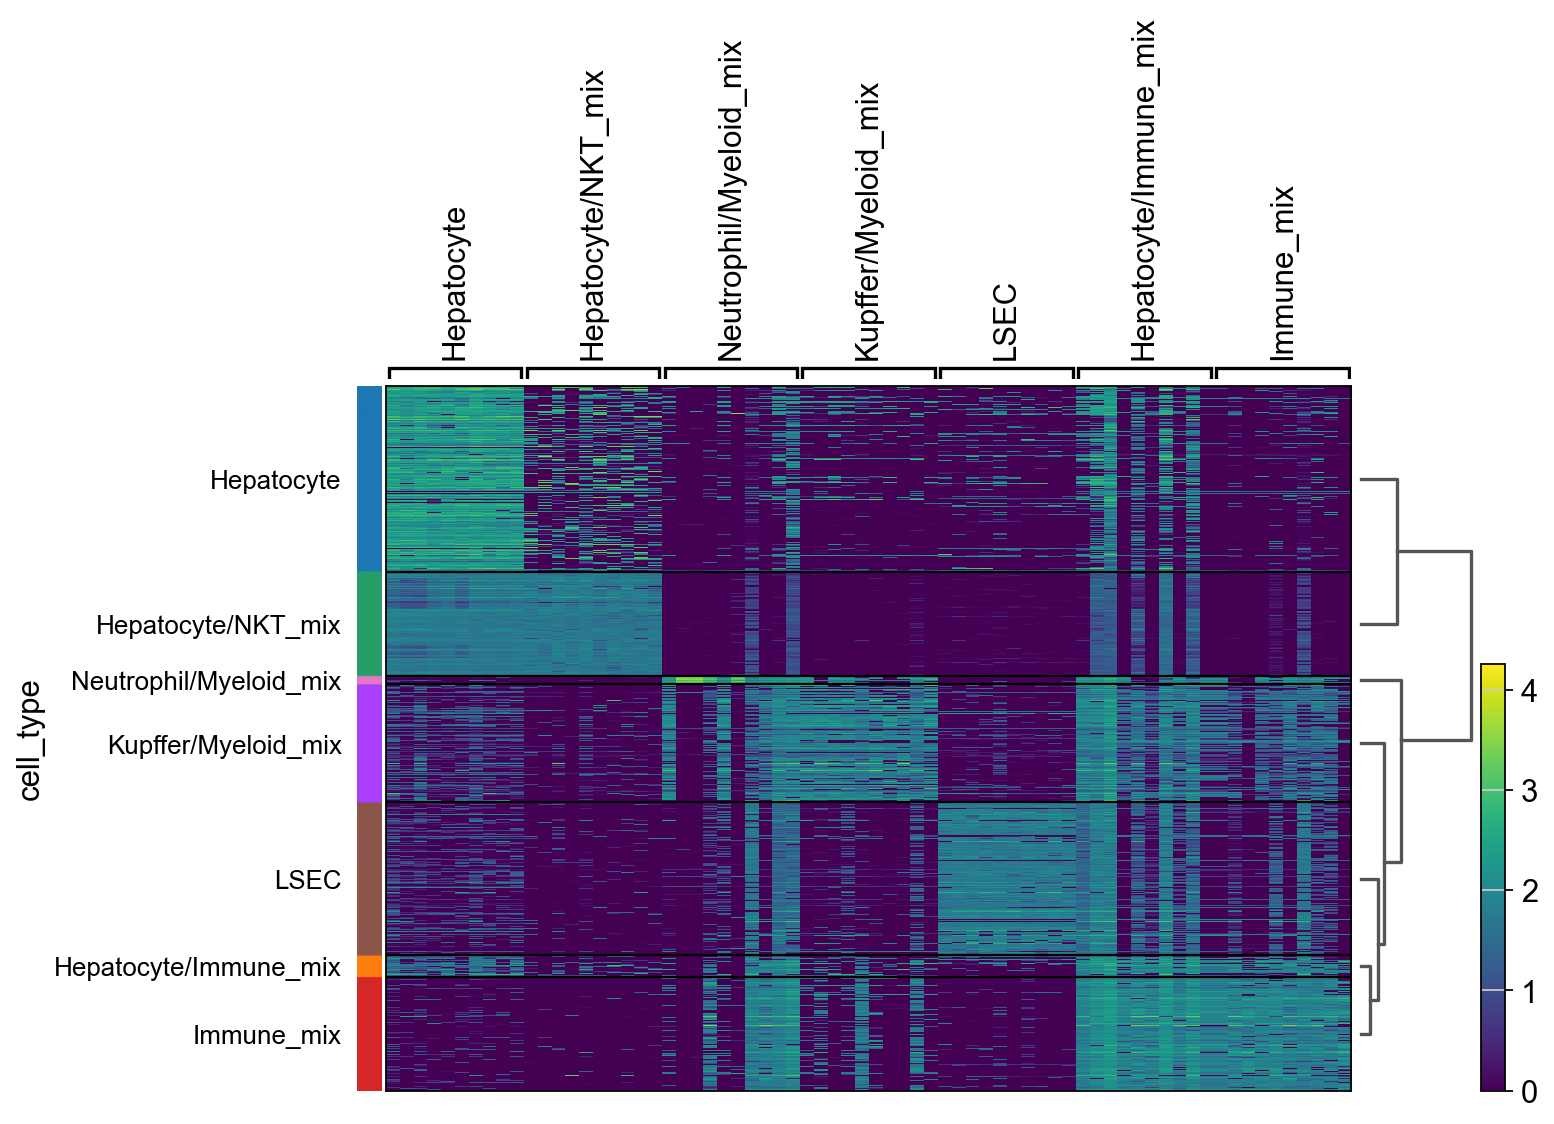

In [14]:
# --- Differentially-Expressed Genes as Markers ---
# This script uses the data-driven `rank_genes_groups` function to find the
# top genes that define each of our manually annotated cell types.

# Setup Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

# 1. Load the AnnData object with your manual cell_type annotations
adata = sc.read_h5ad('Liver_facs_normalized_HVG_reduced_clustered_annotated.h5ad')

# 2. Create a new AnnData object that will hold the log-normalized data.
#    We initialize it with the raw counts from the 'counts' layer.
adata_log = sc.AnnData(adata.layers['counts'].copy())

# 3. CRUCIAL FIX: Copy the gene and cell names from the original object.
adata_log.var_names = adata.var_names
adata_log.obs_names = adata.obs_names

# 3. Perform normalization and log-transformation on this new object.
sc.pp.normalize_total(adata_log, target_sum=1e4)
sc.pp.log1p(adata_log)

# 4. Now, assign this correctly processed object to the .raw attribute of your main adata.
#    This aligns your object with the standard Scanpy workflow.
adata.raw = adata_log

# 2. Calculate differentially expressed genes for each annotated cell type
# This function will compare each cell type against all other cells to find
# genes that are uniquely upregulated. We use the 't-test' method here for speed.
sc.tl.rank_genes_groups(adata, groupby='cell_type', method='t-test', use_raw=True)

# 3. Visualize the top marker genes for each cell type
# This plot shows a bar chart of the top genes ranked by their score (e.g., t-statistic).
print("Displaying top marker genes for each annotated cell type:")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=True)

# 4. Create a heatmap of the top marker genes
# A heatmap can give a more detailed view of the expression patterns of the
# top defining genes across all cell types.
print("\nDisplaying heatmap of top 10 markers per cell type:")
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby="cell_type", show=True)

# --- How to Use This Output for Validation ---
#
# 1. Look at the bar chart for the 'Hepatocyte' group. Are the top genes
#    'Alb', 'Apoa1', 'G6pc', etc.? If YES, your annotation is strongly supported.
#
# 2. Look at the 'Kupffer Cell' group. Are the top genes 'Clec4f', 'Cd68', etc.?
#    If YES, your annotation is supported.

The top differentially expressed genes from each cluster are:
- Hepatocyte: Apoa2, Fabp1, Apoc1:
Apoa2: Highly specific for hepatocytes; considered a robust hepatocyte marker in both bulk and single-cell datasets.

Fabp1: Strongly liver-specific, with high abundance in hepatocytes (with a minor expression in the kidney); generally a reliable hepatocyte marker.

Apoc1: Expressed in hepatocytes but also found in myeloid cells/monocytes to a lesser degree, especially in inflammation and disease settings, so less exclusive for hepatocytes than Apoa2 or Fabp1.

-> Strong corroboration with the marker gene set analysis.

- Hepatocyte/Immune_mix: Tmsb4x, H2-D1, Actb
Tmsb4x: Expressed in immune and parenchymal cells; found in the liver but is not exclusive to hepatocytes and is associated with inflammatory states and cell motility across multiple lineages.

H2-D1: MHC class I gene, generally robustly expressed in all nucleated cells, strongly present in hepatocytes and immune cells; not suitable as a highly cell-type-specific marker.

Actb: Encodes beta-actin, expressed nearly ubiquitously across nearly all cell types; not cell-type-specific at all.

-> Perhaps more immune cells in this cluster than hepatocytes.

- Hepatocyte/NKT_mix: Slc38a4, Ugt3a2, Mug1
Slc38a4: This amino acid transporter is highly expressed in hepatocytes and is used as a marker of hepatocyte identity, but it is also present in other organs at lower expression (e.g., placenta).

Ugt3a2: Expressed mainly in liver hepatocytes but also present in other tissues; some specificity for hepatic cells.

Mug1: Generally considered a mature hepatocyte marker, but potential broader expression hasn't been exhaustively ruled out.

-> Possibly the NKT signature is too low for a differentially expressed analysis to pick up, meaning that the majority of the cluster is composed of hepatocytes.

- Immune_mix: Coro1a, Tmsb10, Ptprcap
Coro1a: Very strong marker for hematopoietic cells, especially lymphocytes; not expressed in hepatocytes.

Tmsb10: Expressed in multiple immune and non-immune cell types; not a highly specific immune marker.

Ptprcap: Very specific for lymphocytes/immune cells.

-> Strong corroboration of the presence of immune cells. Which in specific it cannot specify, a better clustering would need to be done.

- Kupffer/Myeloid_mix: Tyrobp, Ctss, Lyz2
Tyrobp: Marker for myeloid cells including Kupffer cells and neutrophils, but not exclusive; marks microglia and other tissue macrophage populations.

Ctss: Cysteine protease, strongly expressed in myeloid lineages but not unique to Kupffer cells.

Lyz2: Strong marker for myeloid cells, especially monocytes, neutrophils, and tissue macrophages

-> Possibly more myeloid cells than kupffer cells but both are definitely present, corroborating the information of the marker gene set analysis.

- LSEC: Ptprb, Clec4g, Igfbp7
Ptprb: Robust marker of liver sinusoidal endothelial cells (LSEC); good cell-type specificity.

Clec4g: Highly specific for LSEC; an established marker for sinusoidal endothelial cells in the liver.

Igfbp7: High expression in LSEC, used as a marker in current liver single-cell atlases; largely restricted to liver endothelium.

-> Strong corroboration of the marker gene set analysis.

- Neutrophil/Myeloid_mix: Tyrobp, S100a8, S100a9
Tyrobp: As above, found in myeloid lineage including neutrophils; not exclusive to neutrophils.

S100a8/S100a9: Both are highly specific for neutrophils and useful as neutrophil markers in mouse and human; strong cell-type association.

-> Possibly more neutrophil cells than myeloid cells in this cluster, but it still corroborates the marker gene set analysis.